In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import torch
import cv2
from PIL import Image
import albumentations as A
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from torch.optim import Adam
from skimage import io, transform
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
# from torchvision.datasets import ImageFolder
import pandas as pd
import  torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from torchvision import transforms as T
from tqdm import tqdm
import os

np.random.seed(0)
torch.manual_seed(0)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current "directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

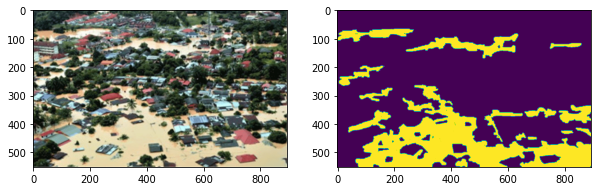

In [4]:
img = plt.imread("/kaggle/input/flood-area-segmentation/Image/0.jpg")[:, :, :3]
mask = plt.imread("/kaggle/input/flood-area-segmentation/Mask/0.png")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img)
axes[1].imshow(mask);

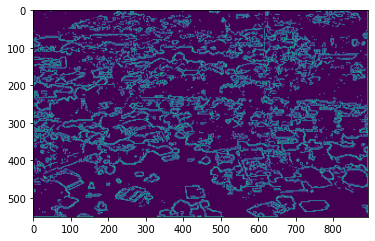

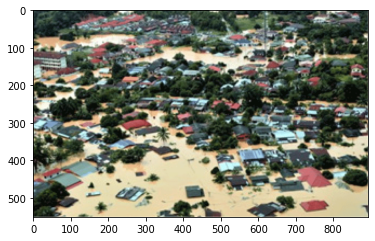

In [5]:
img = plt.imread("/kaggle/input/flood-area-segmentation/Image/0.jpg")[:, :, :3]
# img[(img >= 150)] = 255
# plt.subplot( 1, 1, 1).imshow(cv2.Canny(img, 200, 255))
# plt.subplot(1, 2, 1).imshow(img)
plt.imshow(cv2.Canny(img, 225, 255))
plt.show()
plt.imshow(img)

In [6]:
class FloodDataset(Dataset):
    def __init__(self, csv_file, img_dir, mask_dir, is_train=True, transform=False, channel=True):
        self.img_dir  = img_dir
        self.df = pd.read_csv(csv_file).iloc[1:, :]
        self.mask_dir = mask_dir
        self.channel = channel
        self.transform  = transform
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df.iloc[:, 0], self.df.iloc[:, 1], train_size=0.8)
        if is_train:
            self.images = self.X_train
            self.mask = self.y_train
        else:
            self.images = self.X_test
            self.mask = self.y_test
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        img_path    = os.path.join(self.img_dir, self.images.iloc[index])
        mask_path   = os.path.join(self.mask_dir, self.mask.iloc[index])
        img         = cv2.imread(img_path)
        mask        = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        if self.transform:
            image = self.transform(img)
            mask = self.transform(mask)
#             augmented = self.transform(image=img, mask=mask)
#         image=augmented["image"]
#         mask=augmented["mask"]
#         if self.channel:
#             image = np.swapaxes(image, 0, 2).astype(np.float32)
#             image=np.transpose(image,(2,0,1)).astype(np.float32)
#             mask=np.swapaxes(mask,0,2).astype(np.float32)
        return image, mask

img_dir = "/kaggle/input/flood-area-segmentation/Image"
mask_dir = "/kaggle/input/flood-area-segmentation/Mask"
csv = "/kaggle/input/flood-area-segmentation/metadata.csv"

PATCH_SIZE = 256
batch_size = 6

# transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
#     ToTensorV2()
# ])


def Otsu(img):
    mean = img.mean()
    img[img< mean] = 0
    img[img>mean] = 1
    return img
transforms = T.Compose([T.ToTensor(), T.Resize((PATCH_SIZE, PATCH_SIZE)), T.GaussianBlur(3)])

# transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))])
train_ds = FloodDataset(csv, img_dir, mask_dir, is_train=True,  transform=transforms)
test_ds = FloodDataset(csv, img_dir, mask_dir, is_train=False, transform=transforms)

train_dl = DataLoader(train_ds, batch_size = batch_size,shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size= batch_size, pin_memory=True)

for img, mask in train_dl:
    print(img.shape, mask.shape)
    break

torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


## Image processing

torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


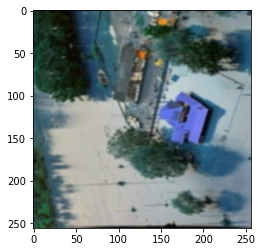

In [7]:
for batch in train_dl:
    img, mask = batch
    print(img.shape, mask.shape)
    break
plt.imshow(img[0].detach().cpu().swapaxes(0, 2))

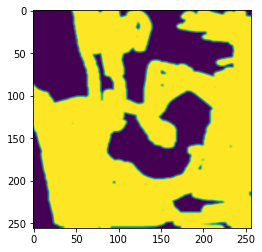

In [8]:
plt.imshow(mask[0].detach().cpu().swapaxes(0, 2))

In [9]:
class IoUScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoUScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
#         inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return IoU
iou = IoUScore()

## ResNextUNet

In [10]:
import torch
from torch import nn
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)
        
        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)
        
        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x


class ResNet50Unet(nn.Module):

    def __init__(self, n_classes=1):
        super().__init__()
        
        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]
        
        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)
                       
        
    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)
        
        return out

In [10]:
epochs = 30
lr = 1e-2
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn   = nn.BCEWithLogitsLoss()
score = IoUScore()
# dice = dice_metric
iou = IoUScore()
model = ResNet50Unet().to(device)
optimizer =  optim.Adam(model.parameters(), lr=lr)

for img, mask in test_dl:
    img, mask = img.to(device), mask.to(device)
    res = model(img )
    print(res.shape)
    break

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

torch.Size([6, 1, 256, 256])


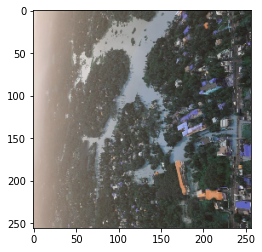

In [10]:
plt.imshow(img.detach().cpu()[0].swapaxes(0, 2))

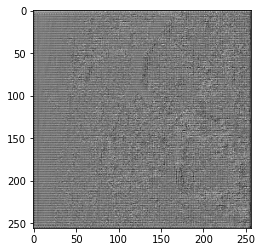

In [11]:
plt.imshow(res.detach().cpu()[0].swapaxes(0, 2), cmap='gray')

In [49]:
num_epochs = 30
learning_rate = 0.001
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss() 
score = iou # IOU score
training_loss = []
valid_loss = []
valid_acc = []
train_acc = []

prev_valid_loss = 100
prev_train_loss = 100
patience = 2
trigger_times = 0

for epoch in range(1, num_epochs+1):
# Training loop
    model.train(True)
    correct = 0
    for X, y in tqdm(train_dl):  
        X, y = X.to(device), y.to(device) 
        opt.zero_grad()
        yhat = model(X) 
        loss = 1- score(y, yhat)
        prev_train_loss = loss
        loss.backward()
        opt.step() 
    training_loss.append(loss.item())
    print(f"Epoch:{epoch} training loss is {loss.item()}")
    
    model.train(False)

    # Valid loop
    correct = 0
    with torch.no_grad():
        for X, y in tqdm(test_dl): 
            X, y = X.to(device), y.to(device) 
            yhat = model(X) 
            loss = 1- score(y, yhat)
            if loss < prev_valid_loss:
                torch.save(model, f"model{loss.item()}.pth")
        valid_loss.append(loss.item())    
        print(f"Epoch:{epoch} valid loss is {loss.item()}")

    # Early stopping
    if loss > prev_valid_loss:
        trigger_times += 1
    if trigger_times > 0 and loss < prev_valid_loss:
        trigger_times -= 1
    if trigger_times == patience:
        break
    prev_valid_loss = loss
    print("Trigger: ", trigger_times)
    print("-"*50)
print("Training complete")

  0%|          | 0/39 [00:00<?, ?it/s]


NameError: name 'device' is not defined

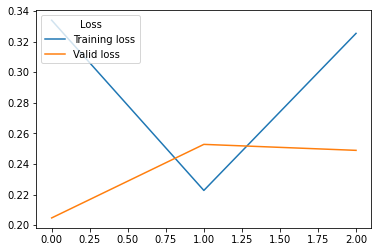

In [13]:
plt.plot(training_loss,label='Training loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend(loc='upper left', title='Loss');

In [11]:
 for img, mask in test_dl:
        res = model(img.to(device))
        break
iou(res.detach().cpu(), mask)

NameError: name 'model' is not defined

In [12]:
plt.imshow(res[0][0].detach().cpu())

NameError: name 'res' is not defined

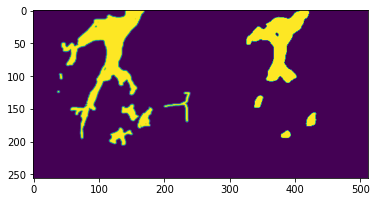

In [16]:
plt.imshow(np.hstack([mask[0].detach().cpu(), res[0].detach().cpu()]).swapaxes(0, 2))